In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier


In [102]:
def get_clf_eval(y_test, y_pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test,pred_proba)

    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [103]:
# dataset 작업요
df = pd.read_csv('./final_datasets.csv', index_col=0)
df.head(1)

,TARGET,자녀 수,가족 구성원 수,나이,가입연수,월간 수입,성별,차량 소유 여부,부동산 소유 여부,수입 유형,...,도시구분,home_shape,car_home,가족크기범주,combinedFY,cons_low,cons_lab,bus_low,bus_drv,bus_lab
0,0,2,4.0,39,23.0,1504500.0,1,1,1,3,...,1,7,3,1,0,0,0,0,0,0


In [104]:
# feature와 label 분리
feature = df.drop('TARGET', axis=1)
label = df['TARGET']

In [105]:
# train test 분리
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3 , random_state=0, stratify=label)

In [106]:
# 언더샘플링 - 소수라벨과 다수라벨 비율 1:1

from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [ ]:
# # 오버샘플링 - 소수라벨과 다수라벨 비율 1:1 / 오버 샘플링이 좋음

# from imblearn.over_sampling import RandomOverSampler
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
# # SMOTE

# from imblearn.over_sampling import SMOTE
# smote_sample = SMOTE(sampling_strategy='minority') 
# X_train, y_train = smote_sample.fit_resample(X_train, y_train)

In [107]:
# 1. Decision Tree를 이용한 학습

dt = DecisionTreeClassifier(random_state=43)

parameters = {'max_depth' : [2, 3, 4, 5],
             'min_samples_split' : [1, 3, 5, 7, 9]}

stratified_cv = StratifiedKFold(n_splits=3)

grid_dt = GridSearchCV(dt, param_grid = parameters, cv=stratified_cv, refit=True)
grid_dt.fit(X_train, y_train)

dt = grid_dt.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_dt.best_params_}")
print(f"최고 예측 정확도: {grid_dt.best_score_:.4f}")

최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_split': 3}
최고 예측 정확도: 0.5931


In [121]:
# 임곗값 조정을 통한 recall값 향상
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
pred_proba = dt.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.45).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test, custom_pred, pred_proba)

오차행렬:
 [[9227 6842]
 [ 778 1150]]

정확도: 0.5766
정밀도: 0.1439
재현율: 0.5965
F1: 0.2319
AUC: 0.6086


In [123]:
# 트리 기반 모델의 특성 중요도 확인
for feature, importance in zip(X_train.columns, dt.feature_importances_):
    print(f"{feature}: {importance}")

자녀 수: 0.0
가족 구성원 수: 0.0
나이: 0.3879057312803064
가입연수: 0.0
월간 수입: 0.0
성별: 0.21070328529060314
차량 소유 여부: 0.06841931682733994
부동산 소유 여부: 0.0
수입 유형: 0.0
최종 학력: 0.3329716666017505
결혼 여부: 0.0
주거 형태: 0.0
휴대전화 소유 여부: 0.0
이메일 소유 여부: 0.0
직업: 0.0
산업군: 0.0
도시구분: 0.0
home_shape: 0.0
car_home: 0.0
가족크기범주: 0.0
combinedFY: 0.0
cons_low: 0.0
cons_lab: 0.0
bus_low: 0.0
bus_drv: 0.0
bus_lab: 0.0


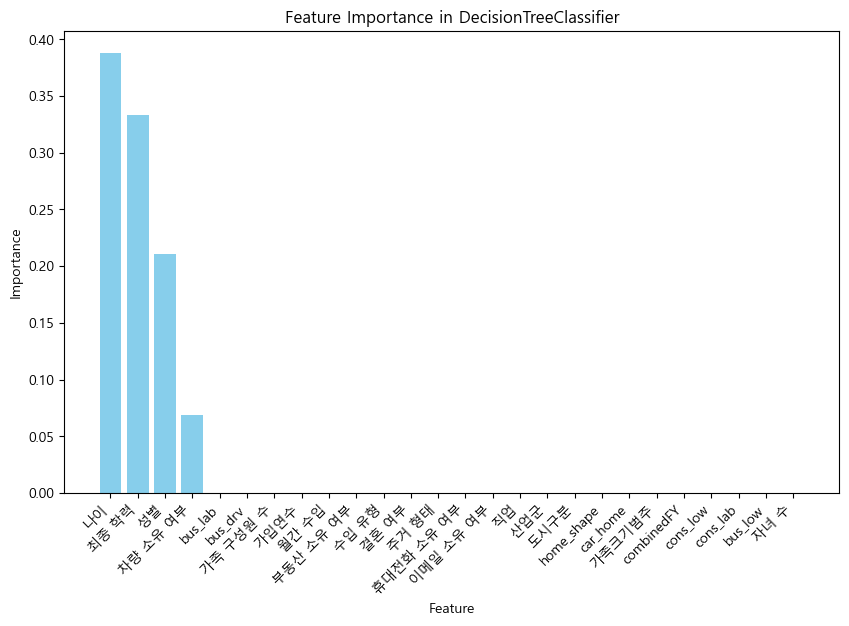

In [131]:
feature_importance = dt.feature_importances_

# 피처 중요도를 기준으로 내림차순 정렬
sorted_idx = np.argsort(feature_importance)[::-1]

# 중요도가 높은 상위 몇 개의 피처를 선택 (예: 상위 10개)
features = sorted_idx

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), feature_importance[features], align="center",color='skyblue')
plt.xticks(range(len(features)), X_train.columns[features], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in DecisionTreeClassifier")
plt.show()

In [125]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [110]:
# # ROC 곡선 및 AUC 계산
# fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
# roc_auc = auc(fpr, tpr)

# # ROC 곡선 시각화
# plt.figure(figsize=(8, 8))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# # 5. 성능 평가
# get_clf_eval(y_test, custom_pred, pred_proba)

In [111]:
# 2. RandomForest를 이용한 학습

rf = RandomForestClassifier(random_state=43)

parameters = {
    'max_depth' : [6, 8, 12],
    'min_samples_split' : [16, 24]
}

stratified_cv = StratifiedKFold(n_splits=3)

grid_rf = GridSearchCV(rf, param_grid = parameters, cv=stratified_cv, refit=True)
grid_rf.fit(X_train, y_train)

rf = grid_rf.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_rf.best_params_}")
print(f"최고 예측 정확도: {grid_rf.best_score_:.4f}")

최적 하이퍼 파라미터: {'max_depth': 6, 'min_samples_split': 24}
최고 예측 정확도: 0.5970


In [112]:
# 임계값 조정 및 적용

rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_proba = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test, custom_pred, pred_proba)


오차행렬:
 [[14955  1114]
 [ 1646   282]]

정확도: 0.8466
정밀도: 0.2020
재현율: 0.1463
F1: 0.1697
AUC: 0.6251


In [113]:
# 3. Logistic regrssion 을 이용한 학습

lr = LogisticRegression(random_state=43)

parameters = {'penalty': ['l2','l1'],
          'C':[0.01,0.1,1,10]}

stratified_cv = StratifiedKFold(n_splits=3)

grid_lr = GridSearchCV(lr, param_grid = parameters, cv=stratified_cv, refit=True)
grid_lr.fit(X_train, y_train)

lr = grid_lr.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_lr.best_params_}")
print(f"최고 예측 정확도: {grid_lr.best_score_:.4f}")

최적 하이퍼 파라미터: {'C': 0.01, 'penalty': 'l2'}
최고 예측 정확도: 0.5000


In [114]:
# 임계값 조정 및 모델 적용
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test , custom_pred, pred_proba)

오차행렬:
 [[16069     0]
 [ 1928     0]]

정확도: 0.8929
정밀도: 0.0000
재현율: 0.0000
F1: 0.0000
AUC: 0.5120


In [115]:
# 4. KNN 을 이용한 학습

knn = KNeighborsClassifier()
# knn에는 무작위성 추출(random_state)를 하지 않음.

parameters = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance']
          }

stratified_cv = StratifiedKFold(n_splits=3)

grid_knn = GridSearchCV(knn, param_grid = parameters, cv=stratified_cv, refit=True)
grid_knn.fit(X_train, y_train)

knn = grid_knn.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_knn.best_params_}")
print(f"최고 예측 정확도: {grid_knn.best_score_:.4f}")

최적 하이퍼 파라미터: {'n_neighbors': 9, 'weights': 'uniform'}
최고 예측 정확도: 0.5363


In [116]:
# 임계값 조정 및 모델 적용

knn.fit(X_train, y_train)
pred = knn.predict(X_test)
pred_proba = knn.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test , custom_pred, pred_proba)

오차행렬:
 [[11798  4271]
 [ 1340   588]]

정확도: 0.6882
정밀도: 0.1210
재현율: 0.3050
F1: 0.1733
AUC: 0.5328


In [117]:
# 5. Lightgbm을 이용한 학습

lgbm= LGBMClassifier(random_state=43)

param_grid = {
    'num_leaves': [20, 30],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'min_child_samples': [20, 30]
}

stratified_cv = StratifiedKFold(n_splits=3)

grid_lgbm = GridSearchCV(lgbm, param_grid = parameters, cv=stratified_cv, verbose=1, refit=True)
grid_lgbm.fit(X_train, y_train)

lgbm = grid_lgbm.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_lgbm.best_params_}")
print(f"최고 예측 정확도: {grid_lgbm.best_score_:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Info] Number of positive: 2999, number of negative: 2999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 5998, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM

In [118]:
# 임계값 조정 및 모델 적용

lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
pred_proba = lgbm.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test , custom_pred, pred_proba)

[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Info] Number of positive: 4499, number of negative: 4499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 8998, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
[LightGBM] [Warning] Unknown parameter: n_neighbors
[LightGBM] [Warning] Unknown parameter: weights
오차행렬:
 [[12703  3366]

In [119]:
# 6. XGboosg 
xgb = XGBClassifier(random_state=43)

parameters = {'learning_rat': [0.01, 0.1],  
              'n_estimators': [50, 100, 200]
          }

stratified_cv = StratifiedKFold(n_splits=3)

grid_xgb = GridSearchCV(xgb, param_grid=parameters, cv=stratified_cv, verbose=1, refit=True)
grid_xgb.fit(X_train, y_train)

xgb = grid_xgb.best_estimator_

print(f"최적 하이퍼 파라미터: {grid_xgb.best_params_}")
print(f"최고 예측 정확도: {grid_xgb.best_score_:.4f}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
최적 하이퍼 파라미터: {'learning_rat': 0.01, 'n_estimators': 50}
최고 예측 정확도: 0.5716


In [120]:
# 임계값 조정 및 모델 적용

xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
pred_proba = xgb.predict_proba(X_test)[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.6).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)

get_clf_eval(y_test , custom_pred, pred_proba)

오차행렬:
 [[12434  3635]
 [ 1190   738]]

정확도: 0.7319
정밀도: 0.1688
재현율: 0.3828
F1: 0.2342
AUC: 0.6131
